In [1]:
import pandas as pd
import numpy as np
# import openai
# from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
import requests
import json
import re

import matplotlib.pyplot as plt
from collections import defaultdict
import random

from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage

from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

In [2]:
# read the data
duo_test_path = r'.\Duo'

cols = ['rating', 'year', 'perspective']
duo_cons = pd.read_excel(duo_test_path + "/duo_cons_topics.xlsx")[cols]
duo_cons['type'] = 'cons'

In [10]:
### Negative Perspective Coding

In [4]:
## Set up the LLM
llm = ChatOpenAI(
    model = "gemma2:27b", # need to pull it first 
    temperature = 0,
    max_tokens = None,
    timeout = None,
    max_retries = 2,
    api_key = "ollama",
    base_url="http://localhost:11434/v1"
    )

### Stage 1: Initial Code Generation

In [7]:
## Setting up prompts with PromptTemplate - Connection Test
# Prompt A
def llm_coder(ux_topic, user_review):
    prompt_template = PromptTemplate.from_template(

        """
        Your task is to classify user reviews into a single user experience topic based on the content of the review. 
        
        ### Instructions:
        1. **Topic Code**:
           - Generate a single-word topic code that captures the primary user experience or usability complaint discussed in the review.
           - If the review fits a previously generated topic code, reuse that code.
           - If none of the existing codes apply, generate a new topic code that best represents the review.
           - If the review does not fit the user experience or usability topic, assign the code "None."
        
        2. **Examples**:
           - Review: 'confusion between present tense and normal tense translations can lead to inconsistencies and may hinder the learning process'
             → Topic: [Inconsistency]
           - Review: "free version has frequent ads"  
             → Topic: [Ads]
           - Review: "lack of explanations for incorrect answers may hinder understanding"  
             → Topic: [Explanation]

        3. **Output Format**:
           - Strictly format your response as:  
             Topic: Code
        
        4. **Previous Generated Topics**:
           - You must only choose from or add to the following list of previously generated topic codes:  
             {UX_code}
        
        ### Review:
        Here is the user review: {user_review}
        
        Provide your response below:
        
        """

        )

    ## Formatting
    prompts = prompt_template.format(UX_code = ux_topic,
                                    user_review = user_review)

    ## Call the model
    res = llm.invoke(prompts).content
    
    return res

In [3]:
def code_extract(text):
    match = re.search(r"Topic:\s*(\w+)", text)
    if match:
        word_after_topic = match.group(1)
    else:
        word_after_topic = 'None'
    return word_after_topic

In [10]:
# test
random_records = duo_cons['perspective'].sample(n=500, random_state=None).tolist()

topics = []
topics_cnt = {}
topics_dic = {}
uni_topic_num = []
pers_num = 0

for per in random_records:
    print('-----------')
    current_topics = ", ".join(list(set(topics)))
    topic = llm_coder(current_topics, per)
    topic = code_extract(topic)
    
    print("Perspective: ", per)
    print("Assigned Topic: ", topic)
    
    topics.append(topic) 
    
    if topic not in topics_dic:
        topics_dic[topic] = [per]
    else:
        topics_dic[topic].append(per)   
    
    if topic not in topics_cnt:
        topics_cnt[topic] = 1
    else:
        topics_cnt[topic] += 1
    
    uni_topic_num.append(len(set(topics)))
    pers_num += 1

-----------
Perspective:  need to stop when you run out of hearts in the free version
Assigned Topic:  Hearts
-----------
Perspective:  encourages regular use with engaging quizzes
Assigned Topic:  Hearts
-----------
Perspective:  annoying frequency of ads and their impact on performance
Assigned Topic:  Ads
-----------
Perspective:  does not support apples text scaling
Assigned Topic:  None
-----------
Perspective:  the suggested feature of testing oneself on a language already known is seen as potentially not useful for most users
Assigned Topic:  None
-----------
Perspective:  the variety of languages offered by including unique languages like klingon is a major advantage
Assigned Topic:  None
-----------
Perspective:  legendary skills purchased with gems can crack like regular skills causing frustration
Assigned Topic:  Hearts
-----------
Perspective:  penalizes for incorrect answers without proper explanation
Assigned Topic:  Explanation
-----------
Perspective:  characters of jap

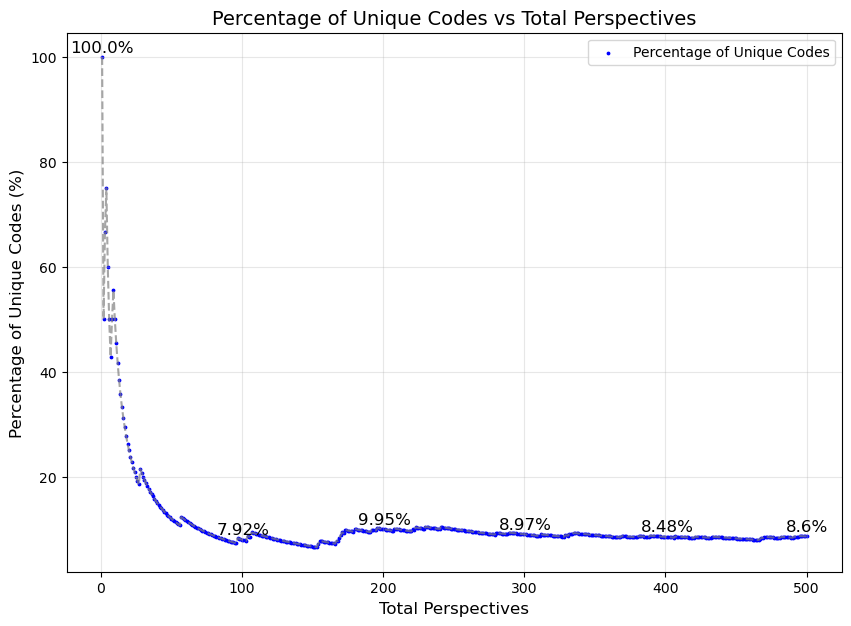

In [12]:
# Example data
x = list(range(1, len(uni_topic_num) + 1))
y = uni_topic_num

# Calculate percentages
percentages = [round(uni_code / total_pers * 100, 2) for total_pers, uni_code in zip(x, y)]

# Plot the dot plot
plt.figure(figsize=(10, 7))
plt.scatter(x, percentages, color='blue', s = 3, label = 'Percentage of Unique Codes')
plt.plot(x, percentages, linestyle='--', color='gray', alpha=0.7)  # Optional: Connect dots with a line for visualization

# Add labels and title
plt.xlabel('Total Perspectives', fontsize=12)
plt.ylabel('Percentage of Unique Codes (%)', fontsize=12)
plt.title('Percentage of Unique Codes vs Total Perspectives', fontsize=14)
plt.grid(alpha=0.3)  # Add a light grid
plt.legend()

# Annotate dots with percentages
for i, perc in enumerate(percentages):
    if (i%100 == 0) or (i == 499):
        plt.text(x[i], percentages[i] + 1, f"{perc}%", ha='center', fontsize=12)

# Show the plot
plt.show()

In [13]:
# Number of bootstraps and sample size
n_bootstraps = 100
sample_size = 100

# Initialize a list to store topics_dic from each bootstrap
all_topics_dic = []

# Bootstrapping
for bootstrap_idx in range(n_bootstraps):
    print(f"Bootstrap Iteration: {bootstrap_idx + 1}")
    
    # Randomly sample 100 perspectives
    random_records = duo_cons['perspective'].sample(n=sample_size, random_state=random.randint(0, 10000)).tolist()
    
    # Initialize variables for this bootstrap
    topics = []
    topics_dic = {}
    
    for per in random_records:
        current_topics = ", ".join(list(set(topics)))
        topic = llm_coder(current_topics, per)  # Call LLM coder
        topic = code_extract(topic)  # Extract the code from LLM response
        
        topics.append(topic)
        
        # Add perspective to topics_dic
        if topic not in topics_dic:
            topics_dic[topic] = [per]
        else:
            topics_dic[topic].append(per)
    
    # Save the topics_dic for this bootstrap iteration
    all_topics_dic.append(topics_dic)


Bootstrap Iteration: 1
Bootstrap Iteration: 2
Bootstrap Iteration: 3
Bootstrap Iteration: 4
Bootstrap Iteration: 5
Bootstrap Iteration: 6
Bootstrap Iteration: 7
Bootstrap Iteration: 8
Bootstrap Iteration: 9
Bootstrap Iteration: 10
Bootstrap Iteration: 11
Bootstrap Iteration: 12
Bootstrap Iteration: 13
Bootstrap Iteration: 14
Bootstrap Iteration: 15
Bootstrap Iteration: 16
Bootstrap Iteration: 17
Bootstrap Iteration: 18
Bootstrap Iteration: 19
Bootstrap Iteration: 20
Bootstrap Iteration: 21
Bootstrap Iteration: 22
Bootstrap Iteration: 23
Bootstrap Iteration: 24
Bootstrap Iteration: 25
Bootstrap Iteration: 26
Bootstrap Iteration: 27
Bootstrap Iteration: 28
Bootstrap Iteration: 29
Bootstrap Iteration: 30
Bootstrap Iteration: 31
Bootstrap Iteration: 32
Bootstrap Iteration: 33
Bootstrap Iteration: 34
Bootstrap Iteration: 35
Bootstrap Iteration: 36
Bootstrap Iteration: 37
Bootstrap Iteration: 38
Bootstrap Iteration: 39
Bootstrap Iteration: 40
Bootstrap Iteration: 41
Bootstrap Iteration: 42
B

In [14]:
# Merge all topics_dic from bootstrapping
merged_topics_dic = defaultdict(list)

for topics_dic in all_topics_dic:
    for topic, perspectives in topics_dic.items():
        merged_topics_dic[topic].extend(perspectives)

In [17]:
# Convert merged_topics_dic to a DataFrame for easier analysis
merged_topics_df = pd.DataFrame(
    [(topic, perspective) for topic, perspectives in merged_topics_dic.items() for perspective in perspectives],
    columns=["Topic", "Perspective"]
)

In [18]:
merged_topics_df = merged_topics_df[merged_topics_df['Topic']!= 'None']
merged_topics_df

,Topic,Perspective
0,Feedback,turning off the microphone to compensate for t...
1,Feedback,limited depth in advanced language learning co...
2,Feedback,lack of comprehensive explanations or tutorial...
3,Feedback,the focus on plus and the restrictions it impo...
4,Feedback,the competitive aspect of the with leaderboard...
...,...,...
9995,Specificity,the is seen as basic and not suitable for seri...
9996,Clickthroughs,there are too many clickthroughs even on the p...
9997,Ethics,the mentions exploiting children online for mo...
9998,Ethics,feels that the developers are not responsive t...


### Stage 2: Code Refinement

In [20]:
codes = merged_topics_df['Topic'].value_counts().index.tolist()
codes = [code for code in codes if str(code) != 'nan']
all_codes_embeddings = [model.encode(code) for code in codes]

In [22]:
def pers_sim(test_perspective):
    test_perspective_embedding = model.encode(test_perspective)
    
    # Compute similarities
    similarities = [util.cos_sim(test_perspective_embedding, code_embedding).item()
                    for code_embedding in all_codes_embeddings]
    
    # Combine codes and their similarity scores
    codes_with_scores = list(zip(codes, similarities))
    
    # Sort by similarity in descending order
    sorted_codes = sorted(codes_with_scores, key=lambda x: x[1], reverse=True)
    
    # Display results
    if sorted_codes[0][1] > 0.3:
        return sorted_codes[0][0]
    else:
        return "Not pass"

In [23]:
# 2nd round coding
merged_topics_df['Topic_2nd_Rd'] = merged_topics_df['Perspective'].apply(pers_sim)

# if the similarity does not pass the cutoff, use the original code
merged_topics_df['Topic_2nd_Rd'] = np.where(merged_topics_df['Topic_2nd_Rd'] == 'Not pass', merged_topics_df['Topic'], merged_topics_df['Topic_2nd_Rd'])

# Concatenation
merged_topics_df['all_topics'] = np.where(merged_topics_df['Topic_2nd_Rd'] == merged_topics_df['Topic'], 
                                          merged_topics_df['Topic'], merged_topics_df['Topic_2nd_Rd'] + " " + merged_topics_df['Topic'])

In [25]:
merged_topics_df.head()

,Topic,Perspective,Topic_2nd_Rd,all_topics
0,Feedback,turning off the microphone to compensate for t...,VoiceRecognition,VoiceRecognition Feedback
1,Feedback,limited depth in advanced language learning co...,Languages,Languages Feedback
2,Feedback,lack of comprehensive explanations or tutorial...,Tutorial,Tutorial Feedback
3,Feedback,the focus on plus and the restrictions it impo...,Restrictions,Restrictions Feedback
4,Feedback,the competitive aspect of the with leaderboard...,Notifications,Notifications Feedback


### Stage 3: Kmeans Clustering with LLM summary chain

In [27]:
# Function to summarize a cluster using LLM
# Prompt B
def llm_summarize_cluster(cluster_codes):
    prompt_template = PromptTemplate.from_template(
        """
        Your task is to summarize the following complaint topics into a single cohesive label:
        
        **Topics**:
        {cluster_codes}

        **Instructions**:
        - Summarize into a single topic label.
        - Be concise and specific.
        - Just return the label.
        
        Provide your response below:
        """
    )
    prompt = prompt_template.format(cluster_codes="\n".join(cluster_codes))
    response = llm.invoke(prompt).content
    return response.strip()

In [28]:
# Kmeans then LLM
codes = merged_topics_df['all_topics'].value_counts().index.tolist()
codes = [code for code in codes if str(code) != 'nan']
embeddings = [model.encode(code) for code in codes]

# Set range of cluster numbers to test
cluster_range = range(5, 12)  # From 5 to 12 clusters

# Dictionary to store cluster summaries
cluster_summaries = {}

for n_clusters in cluster_range:
    print(f"Running K-means with {n_clusters} clusters...")
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    # Map codes to clusters (limit to first 10 elements per cluster for LLM input)
    cluster_to_codes = {cluster: [] for cluster in range(n_clusters)}
    for code, label in zip(codes, cluster_labels):
        if len(cluster_to_codes[label]) < 20:  # Limit to 10 elements
            cluster_to_codes[label].append(code)
    
    # Summarize each cluster
    cluster_labels_summary = {}
    for cluster, cluster_codes in cluster_to_codes.items():
        summary = llm_summarize_cluster(cluster_codes)
        cluster_labels_summary[cluster] = summary
        print(f"Cluster {cluster} ({n_clusters} clusters): {summary}")
    
    # Store summaries for this number of clusters
    cluster_summaries[n_clusters] = cluster_labels_summary

Running K-means with 5 clusters...
Cluster 0 (5 clusters): Learning Experience
Cluster 1 (5 clusters): In-App Motivation & Reward System
Cluster 2 (5 clusters): Software Issues
Cluster 3 (5 clusters): In-App Purchases and Monetization
Cluster 4 (5 clusters): Language Learning & Translation Quality
Running K-means with 6 clusters...
Cluster 0 (6 clusters): Learning Experience Quality
Cluster 1 (6 clusters): In-Game Hearts Economy
Cluster 2 (6 clusters): App Performance Issues
Cluster 3 (6 clusters): In-App Monetization
Cluster 4 (6 clusters): Language Learning & Translation Quality
Cluster 5 (6 clusters): Learning Experience & Gamification
Running K-means with 7 clusters...
Cluster 0 (7 clusters): Speech Recognition and Pronunciation Quality
Cluster 1 (7 clusters): In-Game Hearts Economy
Cluster 2 (7 clusters): Learning Experience
Cluster 3 (7 clusters): In-App Monetization
Cluster 4 (7 clusters): Language Learning & Translation Quality
Cluster 5 (7 clusters): Learning Experience Optimi

In [32]:
# Display or export results
for n_clusters, summaries in cluster_summaries.items():
    print(f"\nCluster Summaries for {n_clusters} Clusters:")
    for cluster, summary in summaries.items():
        print(f"Cluster {cluster}: {summary}")


Cluster Summaries for 5 Clusters:
Cluster 0: Learning Experience
Cluster 1: In-App Motivation & Reward System
Cluster 2: Software Issues
Cluster 3: In-App Purchases and Monetization
Cluster 4: Language Learning & Translation Quality

Cluster Summaries for 6 Clusters:
Cluster 0: Learning Experience Quality
Cluster 1: In-Game Hearts Economy
Cluster 2: App Performance Issues
Cluster 3: In-App Monetization
Cluster 4: Language Learning & Translation Quality
Cluster 5: Learning Experience & Gamification

Cluster Summaries for 7 Clusters:
Cluster 0: Speech Recognition and Pronunciation Quality
Cluster 1: In-Game Hearts Economy
Cluster 2: Learning Experience
Cluster 3: In-App Monetization
Cluster 4: Language Learning & Translation Quality
Cluster 5: Learning Experience Optimization
Cluster 6: Software Bugs and Performance Issues

Cluster Summaries for 8 Clusters:
Cluster 0: Software Bugs and Performance Issues
Cluster 1: In-Game Hearts Economy
Cluster 2: Speech Recognition and Pronunciation Q

### Average Kappa Score for each clsuter codes

In [30]:
# Set up the LLM for "gemma2:9b"
gemma_llm = ChatOpenAI(
    model="gemma2:9b",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key="ollama",
    base_url="http://localhost:11434/v1"
)

# Set up the LLM for "llama3.1"
llama_llm = ChatOpenAI(
    model="llama3.1",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key="ollama",
    base_url="http://localhost:11434/v1"
)

In [30]:
# Function to generate LLM prompt for a given cluster summary and classify reviews
# Prompt C
def llm_labeler(user_review, cluster_summaries, llm):
    cluster_descriptions = "\n".join(
        [f"{i}. {summary}" for i, summary in cluster_summaries.items()]
    )
    prompt_template = PromptTemplate.from_template(
        f"""
        Your task is to classify user reviews into the following UX or usability topic codes based on the descriptions provided:
        
        **Topic Codes**:
        {cluster_descriptions}

        **Output Format**:
           - Strictly format your response as:  
             Topic: code number
        
        ### Review:
        Here is the user review: {user_review}
        
        Provide your response below:
        """
    )
    prompts = prompt_template.format(user_review=user_review)
    res = llm.invoke(prompts).content
    return res

# Iterate through cluster summaries to classify reviews and calculate Cohen's Kappa
average_kappa_scores = {}

# Iterate over the cluster configurations
for n_clusters, summaries in cluster_summaries.items():
    print(f"\nCluster Summaries for {n_clusters} Clusters:")
    for cluster, summary in summaries.items():
        print(f"Cluster {cluster}: {summary}")
    
    # Store Kappa scores for this cluster configuration
    kappas = []

    for iteration in range(5):  # Repeat the process 5 times
        print(f"\nIteration {iteration + 1} for {n_clusters} clusters:")
        
        # Randomly sample 100 user reviews
        random_records = duo_pros['perspective'].sample(n=100, random_state=random.randint(0, 10000)).tolist()
        
        # Get topics from Gemma LLM
        gemma_topics = [
            code_extract(llm_labeler(per, summaries, gemma_llm)) for per in random_records
        ]
        
        # Get topics from Llama LLM
        llama_topics = [
            code_extract(llm_labeler(per, summaries, llama_llm)) for per in random_records
        ]
        
        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(llama_topics, gemma_topics)
        kappas.append(kappa)
        print(f"Iteration {iteration + 1}: Cohen's Kappa = {kappa:.3f}")
    
    # Calculate the average Cohen's Kappa for this cluster configuration
    average_kappa = np.mean(kappas)
    average_kappa_scores[n_clusters] = kappas
    print(f"\nAverage Cohen's Kappa for {n_clusters} clusters: {average_kappa:.3f}")
    


Cluster Summaries for 5 Clusters:
Cluster 0: Learning Experience
Cluster 1: In-App Motivation & Reward System
Cluster 2: Software Issues
Cluster 3: In-App Purchases and Monetization
Cluster 4: Language Learning & Translation Quality

Iteration 1 for 5 clusters:
Iteration 1: Cohen's Kappa = 0.650

Iteration 2 for 5 clusters:
Iteration 2: Cohen's Kappa = 0.704

Iteration 3 for 5 clusters:
Iteration 3: Cohen's Kappa = 0.506

Iteration 4 for 5 clusters:
Iteration 4: Cohen's Kappa = 0.672

Iteration 5 for 5 clusters:
Iteration 5: Cohen's Kappa = 0.564

Average Cohen's Kappa for 5 clusters: 0.619

Cluster Summaries for 6 Clusters:
Cluster 0: Learning Experience Quality
Cluster 1: In-Game Hearts Economy
Cluster 2: App Performance Issues
Cluster 3: In-App Monetization
Cluster 4: Language Learning & Translation Quality
Cluster 5: Learning Experience & Gamification

Iteration 1 for 6 clusters:
Iteration 1: Cohen's Kappa = 0.290

Iteration 2 for 6 clusters:
Iteration 2: Cohen's Kappa = 0.308

It

In [31]:
# Display final results
print("\nFinal Average Kappa Scores Across Cluster Configurations:")
for n_clusters, kappas in average_kappa_scores.items():
    print(f"Clusters: {n_clusters}, Average Cohen's Kappa: {np.mean(kappas):.3f}")


Final Average Kappa Scores Across Cluster Configurations:
Clusters: 5, Average Cohen's Kappa: 0.619
Clusters: 6, Average Cohen's Kappa: 0.240
Clusters: 7, Average Cohen's Kappa: 0.540
Clusters: 8, Average Cohen's Kappa: 0.624
Clusters: 9, Average Cohen's Kappa: 0.530
Clusters: 10, Average Cohen's Kappa: 0.649
Clusters: 11, Average Cohen's Kappa: 0.562


## Original Codes Kappa

0: **Learning Limitations**	

1: **Technical Issues**	

2: **Frustrating Features**	

3: **Lack of Explanations**	

4: **Learning Material Errors**	

In [5]:
# Manual Deciding the Optimal Codes
# Function to generate LLM prompt for a given cluster summary and classify reviews
def llm_labeler(user_review, llm):
    prompt_template = PromptTemplate.from_template(
        f"""
        Your task is to classify user reviews into the following UX or usability topic codes based on the descriptions provided:
        
        **Topic Codes**:
            0: **Learning Limitations**	
            1: **Technical Issues**	
            2: **Frustrating Features**	
            3: **Lack of Explanations**	
            4: **Learning Material Errors**	

        **Output Format**:
           - Strictly format your response as:  
             Topic: code number
        
        ### Review:
        Here is the user review: {user_review}
        
        Provide your response below:
        """
    )
    prompts = prompt_template.format(user_review=user_review)
    res = llm.invoke(prompts).content
    return res

# Store Kappa scores for this cluster configuration
kappas = []

for iteration in range(5):  # Repeat the process 5 times
    print(f"\nIteration {iteration + 1} for original themes:")
    
    # Randomly sample 100 user reviews
    random_records = duo_pros['perspective'].sample(n=100, random_state=random.randint(0, 10000)).tolist()
    
    # Get topics from Gemma LLM
    gemma_topics = [
        code_extract(llm_labeler(per, gemma_llm)) for per in random_records
    ]
    
    # Get topics from Llama LLM
    llama_topics = [
        code_extract(llm_labeler(per, llama_llm)) for per in random_records
    ]
    
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(llama_topics, gemma_topics)
    kappas.append(kappa)
    print(f"Iteration {iteration + 1}: Cohen's Kappa = {kappa:.3f}")

# Calculate the average Cohen's Kappa for this cluster configuration
average_kappa = np.mean(kappas)
print(f"\nAverage Cohen's Kappa for original themes: {average_kappa:.3f}")


Iteration 1 for original themes:
Iteration 1: Cohen's Kappa = 0.534

Iteration 2 for original themes:
Iteration 2: Cohen's Kappa = 0.384

Iteration 3 for original themes:
Iteration 3: Cohen's Kappa = 0.178

Iteration 4 for original themes:
Iteration 4: Cohen's Kappa = 0.403

Iteration 5 for original themes:
Iteration 5: Cohen's Kappa = 0.243

Average Cohen's Kappa for original themes: 0.348
